In [1]:
import os
import yaml
import sys
import datetime
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import wandb
from einops import rearrange, repeat

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom
import mushroom.data.xenium as xenium
import mushroom.data.visium as visium
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [5]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

In [6]:
date_str = re.sub(r' |:|\.', r'_', str(datetime.datetime.today()))
date_str

'2024-01-29_21_25_55_078492'

In [7]:
run_dir = '/data/estorrs/mushroom/data/projects/htan_talk'
mushroom_dir = os.path.join(run_dir, f'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps = [fp for fp in config_fps if 'wandb' not in fp]
config_fps

['/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT225C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1/config.yaml',
 '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-01-25_16_39_25_636084/outputs/config.yaml',
 '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-01-25_18_03_24_580462/outputs/config.yaml',
 '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/S18-9906/config.yaml']

In [8]:
config_fp = '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1/config.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(mushroom_dir, f'{case}_{date_str}', 'outputs')

Path(out_dir).mkdir(parents=True, exist_ok=True)                       

sections_config = yaml.safe_load(open(config_fp))

sections_config

[{'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s0_he.tif'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s1_he.tif'}],
  'id': 's1',
  'position': 5},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s2_xenium.h5ad'}],
  'id': 's2',
  'position': 10},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s3_multiplex.ome.tiff'}],
  'id': 's3',
  'position': 15},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s4_he.tif'}],
  'id': 's4',
  'position': 20},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s5_xenium.h5ad'}],
  'id': 

In [9]:
# one of the xenium sections is detached
sections_config = [entry for entry in sections_config if 's18'!=entry['id']]

In [11]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
official_to_options = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)', 'CD45(D)'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)', 'PR (D)'],
    'ER': ['ER', 'ER-(D)', 'ER (D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
    'a-Amylase': ['a-Amylase'],
    'Hep-Par-1': ['Hep-Par-1 (D)'],
    'Granzyme-B': ['Granzyme B'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1'],
    'PDL1': ['PD-L1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1'],
}
channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}
# channel_mapping = None

In [12]:
mushroom_config = {
    'sections': sections_config,
    'dtype_to_chkpt': None,
    'sae_kwargs': {
        'size': 8,
        'patch_size': 1,
        'encoder_dim': 128,
        'num_clusters': (8, 4, 2,),
        'dtype_to_decoder_dims': {'multiplex': (256, 128, 64,), 'he': (256, 128, 10,), 'visium': (256, 512, 2048,), 'xenium': (256, 256, 256,)},
        'recon_scaler': 1.,
        'neigh_scaler': .01,
        'codebook_dim': 64,
    },
    'trainer_kwargs': {
        'input_ppm': 0.4705882352941177,
        'target_ppm': .01, # 100 microns per tile
        'contrast_pct': None,
        'pct_expression': .05,
        'batch_size': 128,
        'num_workers': 1,
        'devices': 1,
        'accelerator': 'gpu',
        'enable_checkpointing': True,
        'max_epochs': 1,
        'steps_per_epoch': 1000,
        'channel_mapping': channel_mapping,
        'lr': 1e-4,
        'out_dir': out_dir,
        'save_every': 1,
        'log_every_n_steps': 10,
        'logger_type': 'wandb',
        'logger_project': f'{case}_{date_str}',
    },
}

In [13]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:loading spore for he
INFO:root:starting he processing
INFO:root:14 sections detected: ['s0', 's1', 's4', 's7', 's8', 's10', 's11', 's12', 's15', 's16', 's17', 's20', 's23', 's24']
INFO:root:processing sections
INFO:root:generating image data for section s0
INFO:root:generating image data for section s1
INFO:root:generating image data for section s4
INFO:root:generating image data for section s7
INFO:root:generating image data for section s8
INFO:root:generating image data for section s10
INFO:root:generating image data for section s11
INFO:root:generating image data for section s12
INFO:root:generating image data for section s15
INFO:root:generating image data for section s16
INFO:root:generating image data for section s17
INFO:root:generating image data for section s20
INFO:root:generating image data for section s23
INFO:root:generating image data for section s24
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 14 sections detec

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:starting multiplex processing
INFO:root:using 27 channels
INFO:root:7 sections detected: ['s3', 's6', 's14', 's19', 's22', 's25', 's26']
INFO:root:processing sections
INFO:root:generating image data for section s3
INFO:root:generating image data for section s6
INFO:root:generating image data for section s14
INFO:root:generating image data for section s19
INFO:root:generating image data for section s22
INFO:root:generating image data for section s25
INFO:root:generating image data for section s26
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 7 sections detected: [('s3', 'multiplex'), ('s6', 'multiplex'), ('s14', 'multiplex'), ('s19', 'multiplex'), ('s22', 'multiplex'), ('s25', 'multiplex'), ('s26', 'multiplex')]
INFO:root:creating data loade

In [14]:
mushroom.section_ids

[('s0', 'he'),
 ('s1', 'he'),
 ('s2', 'xenium'),
 ('s3', 'multiplex'),
 ('s4', 'he'),
 ('s5', 'xenium'),
 ('s6', 'multiplex'),
 ('s7', 'he'),
 ('s8', 'he'),
 ('s9', 'xenium'),
 ('s10', 'he'),
 ('s11', 'he'),
 ('s12', 'he'),
 ('s13', 'xenium'),
 ('s14', 'multiplex'),
 ('s15', 'he'),
 ('s16', 'he'),
 ('s17', 'he'),
 ('s19', 'multiplex'),
 ('s20', 'he'),
 ('s21', 'xenium'),
 ('s22', 'multiplex'),
 ('s23', 'he'),
 ('s24', 'he'),
 ('s25', 'multiplex'),
 ('s26', 'multiplex')]

In [15]:
mushroom.train()

INFO:root:starting training for he
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.874    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training he, saved chkpt to /data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-01-29_21_25_55_078492/outputs/he_chkpts/last.ckpt
INFO:root:starting training for multiplex
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.918    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-01-29_21_25_55_078492/outputs/multiplex_chkpts/last.ckpt
INFO:root:starting training for xenium
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.2 M 
------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.992    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training xenium, saved chkpt to /data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-01-29_21_25_55_078492/outputs/xenium_chkpts/last.ckpt


In [47]:
mushroom.embed_sections()

INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:finished integration, found 14 clusters


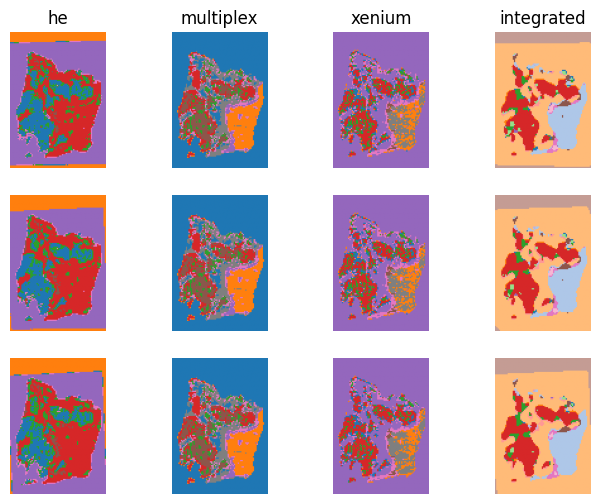

In [48]:
level = 0
z_scaler = .1
resolution = 2.
weights = {
    'multiplex': 1.,
    'he': 1.,
    'xenium': 1.
}
dtype_to_volume = mushroom.generate_interpolated_volumes(
    z_scaler=z_scaler, level=level, resolution=resolution, dtype_to_weight=weights)
mushroom.display_volumes(positions=[1,2,3], figsize=(8, 6))

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:finished integration, found 14 clusters


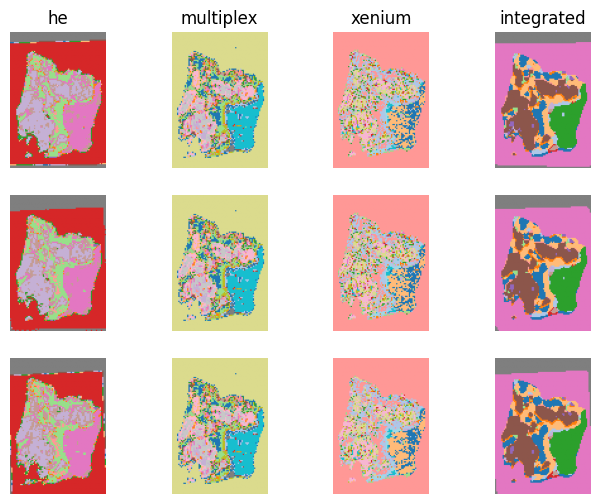

In [49]:
level = 1
z_scaler = .1
resolution = 2.
weights = {
    'multiplex': 1.,
    'he': 1.,
    'xenium': 1.
}
dtype_to_volume = mushroom.generate_interpolated_volumes(
    z_scaler=z_scaler, level=level, resolution=resolution, dtype_to_weight=weights)
mushroom.display_volumes(positions=[1,2,3], figsize=(8, 6))

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:finished integration, found 16 clusters


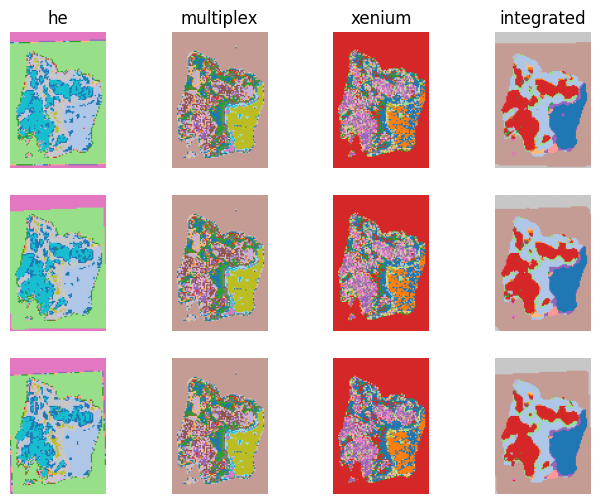

In [50]:
level = 2
z_scaler = .1
resolution = 2.
weights = {
    'multiplex': 1.,
    'he': 1.,
    'xenium': 1.
}
dtype_to_volume = mushroom.generate_interpolated_volumes(
    z_scaler=z_scaler, level=level, resolution=resolution, dtype_to_weight=weights)
mushroom.display_volumes(positions=[1,2,3], figsize=(8, 6))

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:finished integration, found 23 clusters


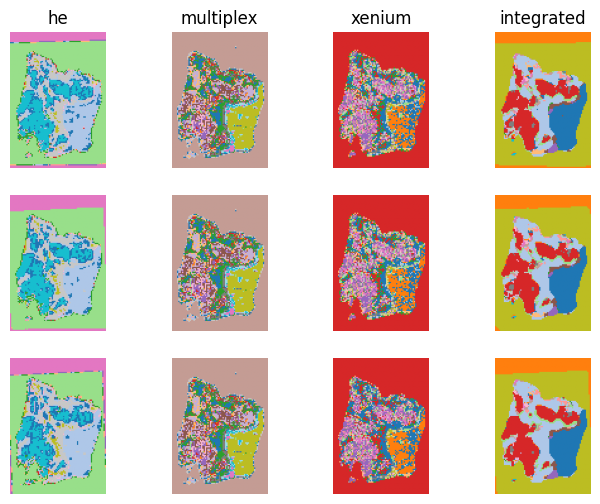

In [53]:
level = 2
z_scaler = .1
resolution = 3.
weights = {
    'multiplex': 1.,
    'he': 1.,
    'xenium': 1.
}
dtype_to_volume = mushroom.generate_interpolated_volumes(
    z_scaler=z_scaler, level=level, resolution=resolution, dtype_to_weight=weights)
mushroom.display_volumes(positions=[1,2,3], figsize=(8, 6))

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:finished integration, found 27 clusters


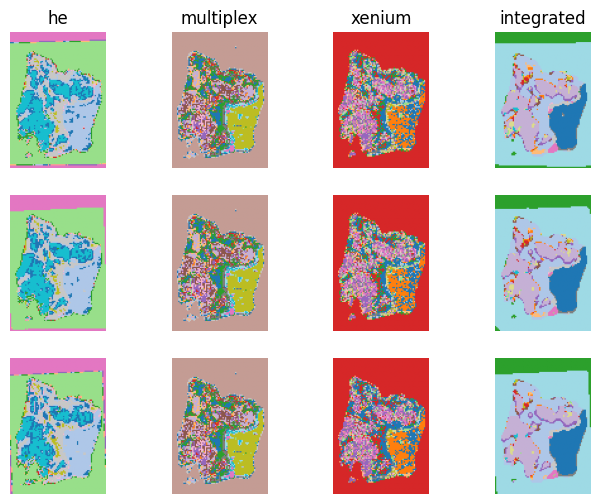

In [63]:
level = 2
z_scaler = .1
resolution = 2.
weights = {
    'multiplex': 1.,
    'he': 1.,
    'xenium': 1.
}
dtype_to_volume = mushroom.generate_interpolated_volumes(
    z_scaler=z_scaler, level=level, resolution=resolution, dtype_to_weight=weights, dist_thresh=.4)
mushroom.display_volumes(positions=[1,2,3], figsize=(8, 6))

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:finished integration, found 25 clusters


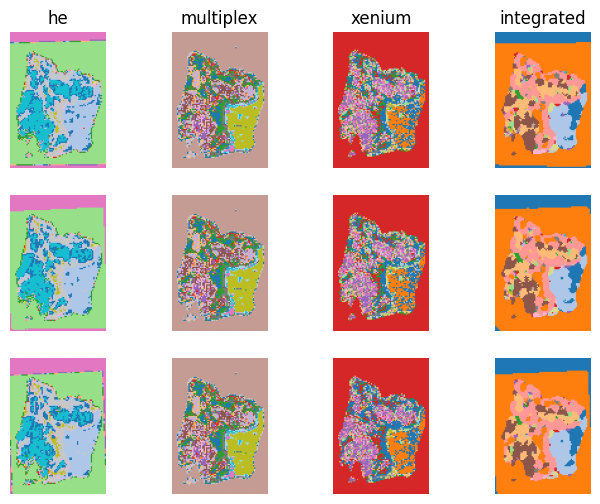

In [77]:
level = 2
z_scaler = .1
resolution = 2.
weights = {
    'multiplex': 1.,
    'he': 1.,
    'xenium': 5.
}
dtype_to_volume = mushroom.generate_interpolated_volumes(
    z_scaler=z_scaler, level=level, resolution=resolution, dtype_to_weight=weights, dist_thresh=.4)
mushroom.display_volumes(positions=[1,2,3], figsize=(8, 6))

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:finished integration, found 22 clusters


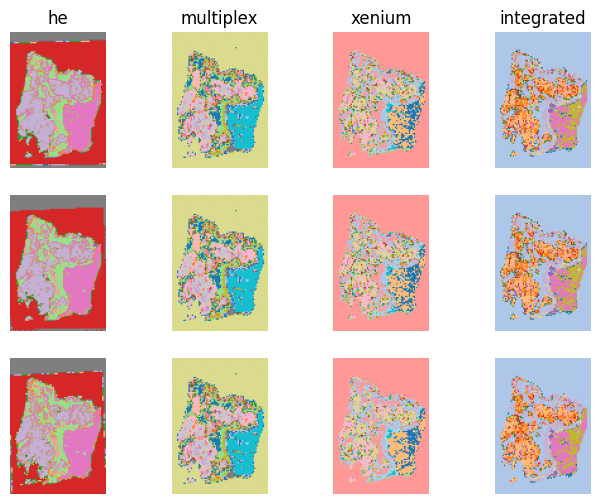

In [79]:
level = 1
z_scaler = .1
resolution = 2.
weights = {
    'multiplex': 1.,
    'he': 1.,
    'xenium': 5.
}
dtype_to_volume = mushroom.generate_interpolated_volumes(
    z_scaler=z_scaler, level=level, resolution=resolution, dtype_to_weight=weights, dist_thresh=.4, kernel_size=None)
mushroom.display_volumes(positions=[1,2,3], figsize=(8, 6))

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:finished integration, found 19 clusters


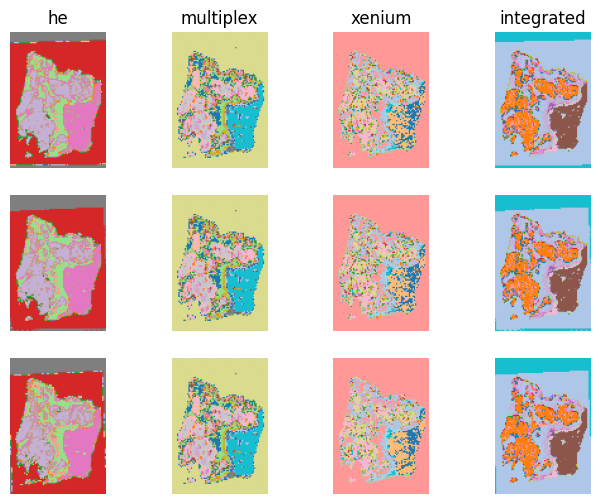

In [80]:
level = 1
z_scaler = .1
resolution = 2.
weights = {
    'multiplex': 1.,
    'he': 1.,
    'xenium': 1.
}
dtype_to_volume = mushroom.generate_interpolated_volumes(
    z_scaler=z_scaler, level=level, resolution=resolution, dtype_to_weight=weights, dist_thresh=.4, kernel_size=None)
mushroom.display_volumes(positions=[1,2,3], figsize=(8, 6))

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:finished integration, found 20 clusters


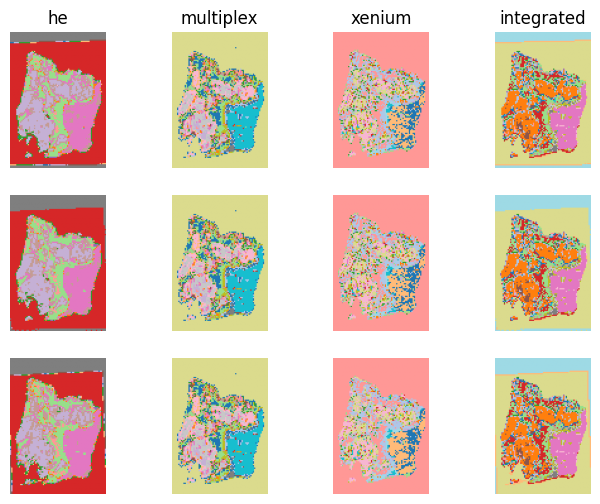

In [191]:
level = 1
z_scaler = .1
resolution = 2.
weights = {
    'multiplex': 2.,
    'he': 2.,
    'xenium': 1.
}
dtype_to_volume = mushroom.generate_interpolated_volumes(
    z_scaler=z_scaler, level=level, resolution=resolution, dtype_to_weight=weights, dist_thresh=.4, kernel_size=None)
mushroom.display_volumes(positions=[1,2,3], figsize=(8, 6))

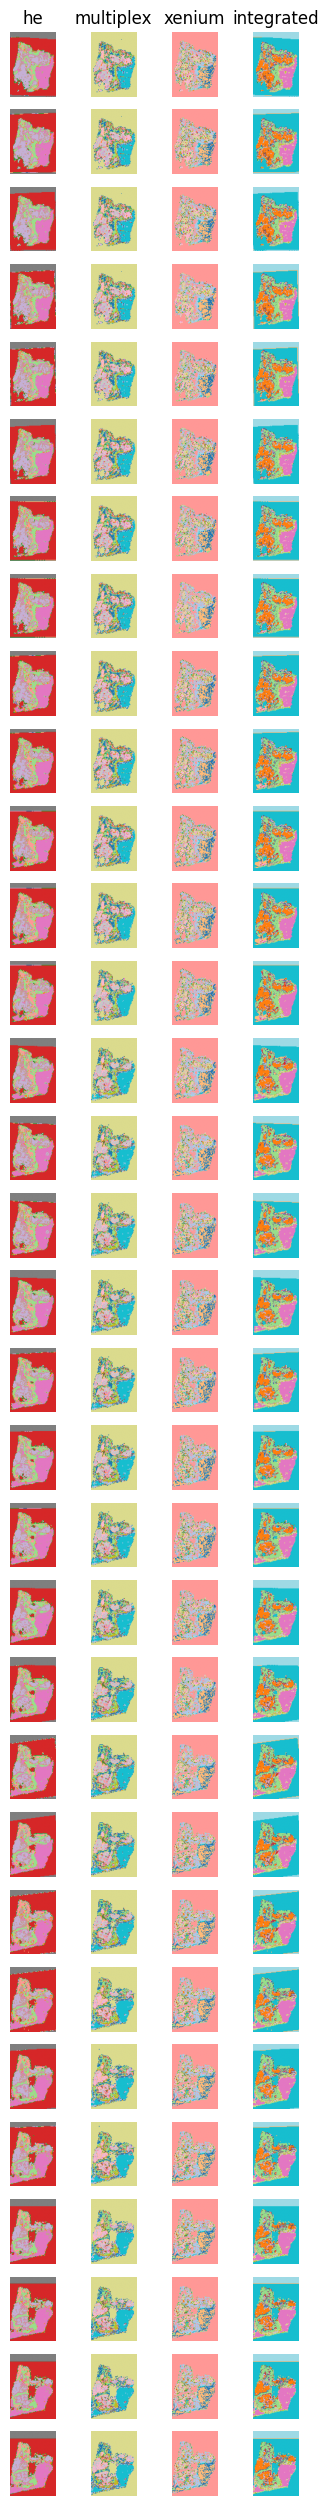

In [83]:
mushroom.display_volumes()

In [84]:
dtype_to_df = mushroom.calculate_cluster_intensities(use_integrated=False)
dtype_to_df['xenium']

ABCC11      ACAN      ACE2     ACKR1     ACTA2     ACTG2    ADAM28  \
0   0.365731 -0.137625  0.233182  0.143261 -0.182108 -0.156214 -0.060091   
1   0.139927 -0.229060  0.058397  0.014572 -0.110867 -0.294362 -0.146517   
2   0.514722 -0.139618  0.318931  0.169189 -0.212341 -0.080851 -0.092953   
3   0.176194  0.658260  0.472934  0.501339  1.093785  1.123039  1.168462   
4   0.239293  0.056842  0.238210  0.260689  0.277213  0.185865  0.380390   
5   0.162523  1.120355  0.450586  0.503257  1.727717  1.391126  1.631925   
6  -0.150239 -0.226479 -0.303525 -0.289016 -0.453536 -0.550272 -0.466457   
7   0.118643  1.255821  0.221837  0.341557  2.058643  0.964760  1.806897   
8   0.151613  0.895302  0.175953  0.289438  1.558007  0.679345  1.426128   
9   0.315681  0.170292  0.257731  0.250425  0.499310  0.139453  0.547115   
10  0.206689  0.394860  0.604645  0.574566  0.654125  1.170431  0.876236   
11  0.282158  1.000851  1.053453  0.892733  1.153225  2.417373  1.423761   
12  0.357441  0.606945  1.290350  0.968683  0.550487  2.459046  0.989671   
13  0.247337  0.605188  0.845816  0.709954  0.799263  1.709971  1.030480   
14  0.192159  1.099053  0.771096  0.688822  1.481373  1.936313  1.531549   
15  0.348269  0.532966  1.132123  0.866183  0.554342  2.105923  0.966561   
16  0.074254  1.677951  0.149160  0.286484  2.834434  0.884706  2.428462   
17  0.063650  1.043177  0.048666  0.248563  1.932552  0.421319  1.693588   
18  0.325715  0.291319  0.259120  0.269322  0.699802  0.203477  0.673803   
19  0.149488 -0.164343  0.117562  0.193746  0.112072 -0.096398  0.141600   
20 -0.067022 -0.161250 -0.130862 -0.086660  0.505616 -0.276761  0.125403   
21 -0.009754  0.070183 -0.018221  0.038301  0.797260 -0.050744  0.499492   
22  0.194443  0.191731  0.521248  0.486593  0.372261  0.905928  0.651214   
23  0.147371  0.011384  0.247646  0.304680  0.193986  0.342882  0.343230   
24 -0.093147 -0.229722 -0.155999 -0.128100  0.004985 -0.335838 -0.138112   
25  0.145523  0.281410  0.226360  0.298124  0.656729  0.452411  0.739702   
26  0.236742  0.161355  0.719144  0.623478  0.212385  1.233989  0.606063   
27  0.276147  1.262082  1.021277  0.885256  1.437140  2.485019  1.665781   
28  0.391454  0.298725  1.570688  1.055596  0.052683  2.600832  0.743478   
29  0.137886  0.314341  0.197227  0.216177  0.722560  0.399282  0.797524   
30  0.284771  0.219334  0.950728  0.766950  0.144473  1.715614  0.644713   
31  0.160817  1.629209  0.742623  0.757167  2.197358  2.264807  2.099750   
32  0.332333  0.249388  1.207820  0.881353  0.044646  2.061458  0.658856   
33  0.032769  2.574445  0.184365  0.428714  3.777303  1.727865  3.097234   
34 -0.004405  0.417121 -0.024605  0.130443  1.356120  0.044248  1.015684   

     ADAMTS1    ADGRE1    ADGRL4  ...     UCHL1      UMOD     UPK3B      VCAN  \
0   0.285453  0.064714 -0.025260  ... -0.145443 -0.045530 -0.065737 -0.290378   
1   0.077005 -0.084303 -0.206418  ...  0.021282 -0.102519 -0.099913 -0.061234   
2   0.450151  0.072012  0.021021  ... -0.212623 -0.031962 -0.033508 -0.466504   
3   1.036641  0.648246  1.200748  ...  0.801696  0.407220  0.323081  1.220250   
4   0.455076  0.313646  0.232224  ...  0.285903  0.123732  0.055802  0.403771   
5   1.621008  0.712335  1.849760  ...  1.018237  0.389657  0.340027  1.748097   
6  -0.443406 -0.341451 -0.501552  ... -0.411391 -0.221366 -0.162124 -0.492711   
7   2.013134  0.567099  1.804774  ...  1.033337  0.227032  0.191607  2.132114   
8   1.562894  0.475795  1.299641  ...  0.831092  0.162499  0.131507  1.694633   
9   0.738264  0.259734  0.376928  ...  0.339953  0.054123  0.037258  0.540941   
10  0.574490  0.671181  0.838435  ...  0.683423  0.488897  0.345880  0.798801   
11  0.932858  1.100076  1.946697  ...  0.926324  0.780861  0.664339  0.946320   
12  0.347911  1.166385  1.430772  ...  0.805823  0.894489  0.750938  0.402082   
13  0.627905  0.864597  1.208298  ...  0.803119  0.674409  0.502756  0.825121   
14  1.297693  0.882051  1.959311  ...  0.973263  0.602

In [93]:
dtype_to_df = mushroom.calculate_cluster_intensities(use_integrated=True, level=1)
dtype_to_df['xenium']

ABCC11      ACAN      ACE2     ACKR1     ACTA2     ACTG2    ADAM28  \
0   0.026050  0.113863  0.109597  0.141073  0.432249  0.262082  0.378914   
1   0.161999  0.366768  0.607318  0.513032  0.555006  1.217016  0.732598   
2   0.219966  0.474768  0.822129  0.656606  0.613005  1.619289  0.866197   
3  -0.091032 -0.188395 -0.224034 -0.196867 -0.334046 -0.449095 -0.329945   
4   0.014553  0.167657  0.082529  0.127702  0.468327  0.226291  0.426528   
5  -0.047759 -0.053135 -0.091921 -0.051920  0.195406 -0.141390  0.059389   
6   0.105074  0.259130  0.429070  0.369529  0.448545  0.880410  0.560009   
7   0.097398  0.932573  0.334130  0.366880  1.526886  1.025585  1.367523   
8   0.012825  0.175050  0.087342  0.114332  0.570029  0.266551  0.462693   
9   0.113484  0.452560  0.437941  0.407509  0.740396  0.988013  0.803074   
10  0.234899  0.612434  0.900306  0.706168  0.757782  1.811321  1.008028   
11  0.027906  0.197049  0.076897  0.126155  0.625452  0.212952  0.513077   
12  0.411254 -0.086851  0.226936  0.144894 -0.143902 -0.090067 -0.049747   
13  0.372562 -0.080406  0.206989  0.137858 -0.136994 -0.078822 -0.042342   
14 -0.022346  0.007850 -0.012109  0.025240  0.330345  0.029071  0.207036   
15  0.148200  0.484746  0.128134  0.194604  0.952244  0.293162  0.843858   
16  0.175596  0.355974  0.128268  0.166046  0.771948  0.177698  0.672189   
17  0.186800  0.169016  0.108462  0.121613  0.471878  0.036557  0.402845   
18 -0.123573 -0.192765 -0.257129 -0.229767 -0.364502 -0.482713 -0.369052   
19 -0.146783 -0.214075 -0.295656 -0.265339 -0.418472 -0.545065 -0.424706   

     ADAMTS1    ADGRE1    ADGRL4  ...     UCHL1      UMOD     UPK3B      VCAN  \
0   0.338291  0.181369  0.265488  ...  0.425111  0.094642  0.042757  0.644795   
1   0.447377  0.629908  0.824871  ...  0.631332  0.443993  0.343185  0.649217   
2   0.491627  0.804654  1.049268  ...  0.713794  0.586965  0.463418  0.641419   
3  -0.297380 -0.238080 -0.378932  ... -0.270940 -0.170435 -0.128077 -0.339798   
4   0.397319  0.178716  0.304519  ...  0.390262  0.079207  0.032835  0.651489   
5   0.101857 -0.063072 -0.070333  ...  0.211034 -0.062346 -0.070873  0.386482   
6   0.344592  0.463699  0.602782  ...  0.515589  0.313933  0.242046  0.564398   
7   1.429609  0.516105  1.399513  ...  0.857256  0.297715  0.199568  1.593924   
8   0.453543  0.173788  0.343710  ...  0.493397  0.064543  0.033687  0.798885   
9   0.633829  0.519096  0.860668  ...  0.627078  0.337512  0.250464  0.836675   
10  0.630904  0.875432  1.252603  ...  0.765884  0.635092  0.513565  0.730544   
11  0.540858  0.177227  0.348989  ...  0.500536  0.063390  0.021572  0.866179   
12  0.364126  0.058456  0.017878  ... -0.112430 -0.019546 -0.027148 -0.258025   
13  0.325128  0.061696  0.014793  ... -0.099406 -0.011686 -0.028442 -0.232799   
14  0.212480  0.041953  0.069311  ...  0.349629  0.003458 -0.028201  0.565396   
15  1.058435  0.251328  0.713588  ...  0.510401  0.074503  0.019739  1.059100   
16  0.923963  0.194336  0.540974  ...  0.420083  0.039325  0.006258  0.867828   
17  0.657104  0.115112  0.293058  ...  0.280011 -0.002589 -0.020763  0.565001   
18 -0.352299 -0.271517 -0.411005  ... -0.317115 -0.189357 -0.136053 -0.384580   
19 -0.412458 -0.311546 -0.464900  ... -0.369819 -0.214461 -0.150733 -0.451256   

       VEGFA       VIM    VPREB1     VSIG4     VWA5A       VWF  
0   0.203646  0.585772  0.128631  0.300918  0.179445  0.235624  
1   1.238782  0.910148  0.526183  0.469876  0.929645  0.496693  
2   1.658877  1.029888  0.682533  0.538399  1.243604  0.589141  
3  -0.435649 -0.433218 -0.190646 -0.292022 -0.357619 -0.269802  
4   0.155327  0.636141  0.120268  0.341644  0.168404  0.291777  
5  -0.193865  0.198029 -0.066359  0.054372 -0.133546 -0.016991  
6   0.886899  0.720742  0.374213  0.354494  0.664968  0.360355  
7   0.776617  1.897337  0.401590  1.034540  0.915066  1.073162  
8   0.183835  0.735490  0.107659  0.379321  0.205657  0.303017  
9   0.940846  1.064041  0.416827  0.549339  0.784600  0.5

In [183]:
import mushroom.data.datasets as datasets
datasets.get_config_info(sections_config, 'xenium')

({'s2': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s2_xenium.h5ad',
  's5': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s5_xenium.h5ad',
  's9': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s9_xenium.h5ad',
  's13': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s13_xenium.h5ad',
  's21': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s21_xenium.h5ad'},
 ['s2', 's5', 's9', 's13', 's21'],
 ['/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s2_xenium.h5ad',
  '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s5_xenium.h5ad',
  '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s9_xenium.h5ad',
  '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s13_xenium.h5ad',
  '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s21_xe

In [206]:
adata = xenium.adata_from_xenium('/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s5_xenium.h5ad')
adata

AnnData object with n_obs × n_vars = 105239 × 477
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_original'

In [185]:
mushroom.section_ids

[('s0', 'he'),
 ('s1', 'he'),
 ('s2', 'xenium'),
 ('s3', 'multiplex'),
 ('s4', 'he'),
 ('s5', 'xenium'),
 ('s6', 'multiplex'),
 ('s7', 'he'),
 ('s8', 'he'),
 ('s9', 'xenium'),
 ('s10', 'he'),
 ('s11', 'he'),
 ('s12', 'he'),
 ('s13', 'xenium'),
 ('s14', 'multiplex'),
 ('s15', 'he'),
 ('s16', 'he'),
 ('s17', 'he'),
 ('s19', 'multiplex'),
 ('s20', 'he'),
 ('s21', 'xenium'),
 ('s22', 'multiplex'),
 ('s23', 'he'),
 ('s24', 'he'),
 ('s25', 'multiplex'),
 ('s26', 'multiplex')]

In [207]:
level = 1
adata.obs['integrated_neighborhood'] = [str(i) for i in mushroom.assign_pts(adata.obsm['spatial'], ('s5', 'xenium'), 'integrated', level=level)]
adata.obs['xenium_neighborhood'] = [str(i) for i in mushroom.assign_pts(adata.obsm['spatial'], ('s5', 'xenium'), 'xenium', level=level, use_volume=True)]
adata.obs['multiplex_neighborhood'] = [str(i) for i in mushroom.assign_pts(adata.obsm['spatial'], ('s5', 'xenium'), 'multiplex', use_volume=True, level=level)]
adata.obs['he_neighborhood'] = [str(i) for i in mushroom.assign_pts(adata.obsm['spatial'], ('s5', 'xenium'), 'he', use_volume=True, level=level)]
adata.obs

x_centroid   y_centroid  transcript_counts  control_probe_counts  \
cell_id                                                                         
aaaakgka-1   846.782349  1269.916504                106                     0   
aaabamlb-1   836.795288  1271.207642                 84                     0   
aaabjphp-1   856.417542  1271.678833                 78                     0   
aaabkneo-1   823.391846  1271.286011                266                     0   
aaacddce-1   848.736084  1274.679199                 72                     0   
...                 ...          ...                ...                   ...   
oioldpbf-1  3395.203857  2593.349121                388                     0   
oiolgmmf-1  3351.407227  2559.825684                290                     0   
oiombkbi-1  3387.867432  2560.065918                179                     0   
oiommdca-1  3413.359863  2572.195068                261                     0   
oiommdfb-1  3374.823730  2590.044189                328                     0   

            control_codeword_counts  unassigned_codeword_counts  \
cell_id                                                           
aaaakgka-1                        0                           0   
aaabamlb-1                        0                           0   
aaabjphp-1                        0                           0   
aaabkneo-1                        0                           0   
aaacddce-1                        0                           0   
...                             ...                         ...   
oioldpbf-1                        0                           0   
oiolgmmf-1                        0                           0   
oiombkbi-1                        0                           0   
oiommdca-1                        0                           0   
oiommdfb-1                        0                           0   

            deprecated_codeword_counts  total_counts   cell_area  \
cell_id                                                            
aaaakgka-1                           0           106   37.840939   
aaabamlb-1                           0            84   37.253908   
aaabjphp-1                           0            78   70.037346   
aaabkneo-1                           0           266  113.387348   
aaacddce-1                           0            72   28.222657   
...                                ...           ...         ...   
oioldpbf-1                           0           388  241.360165   
oiolgmmf-1                           0           290  111.310160   
oiombkbi-1                           0           179   83.042347   
oiommdca-1                           0           261  380.125326   
oiommdfb-1                           0           328  174.348288   

            nucleus_area integrated_neighborhood xenium_neighborhood  \
cell_id                                                                
aaaakgka-1     28.809689                       6                   7   
aaabamlb-1     17.836719                       2                   5   
aaabjphp-1     25.829376                       6                   7   
aaabkneo-1     63.038127                       2                   5   
aaacddce-1     25.603595                       6                   7   
...                  ...                     ...                 ...   
oioldpbf-1     28.448439                      17                   7   
oiolgmmf-1     37.253908                      12                   0   
oiombkbi-1     19.146251                      17                   7   
oiommdca-1     24.294063                      17                   7   
oiommdfb-1     10.160157                      17                   7   

           multiplex_neighborhood he_neighborhood  
cell_id                                            
aaaakgka-1                      0               7  
aaabamlb-1                     13              11  
aaabjphp-1                      0               7  
aaabk

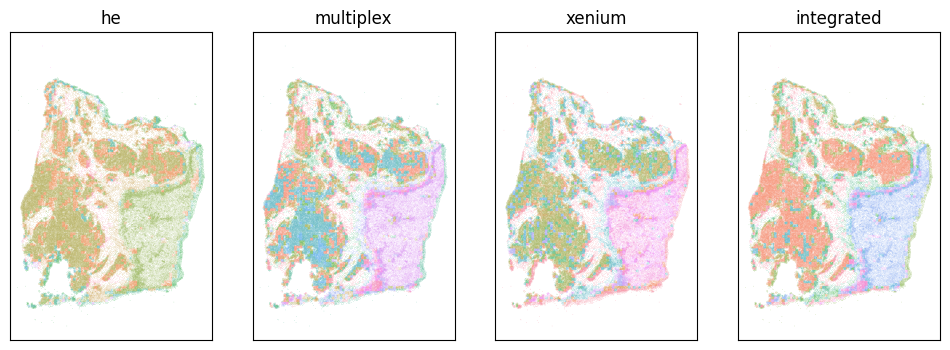

In [208]:
fig, axs = plt.subplots(ncols=4, figsize=(12, 4))
for ax, name in zip(axs, ['he', 'multiplex', 'xenium', 'integrated']):
    sns.scatterplot(x=adata.obsm['spatial'][:, 0], y=-adata.obsm['spatial'][:, 1],
                    hue=adata.obs[f'{name}_neighborhood'], s=.1, ax=ax, legend=None)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(name)


In [209]:
adata.write_h5ad('/data/estorrs/sandbox/HT413C1_U2_xenium.h5ad')

... storing 'integrated_neighborhood' as categorical
... storing 'xenium_neighborhood' as categorical
... storing 'multiplex_neighborhood' as categorical
... storing 'he_neighborhood' as categorical


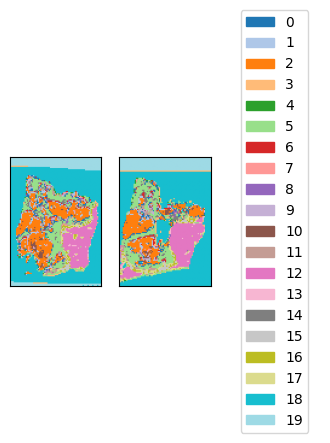

In [95]:
mushroom.display_clusters('integrated', level=1, section_idxs=[0,-1])

[]

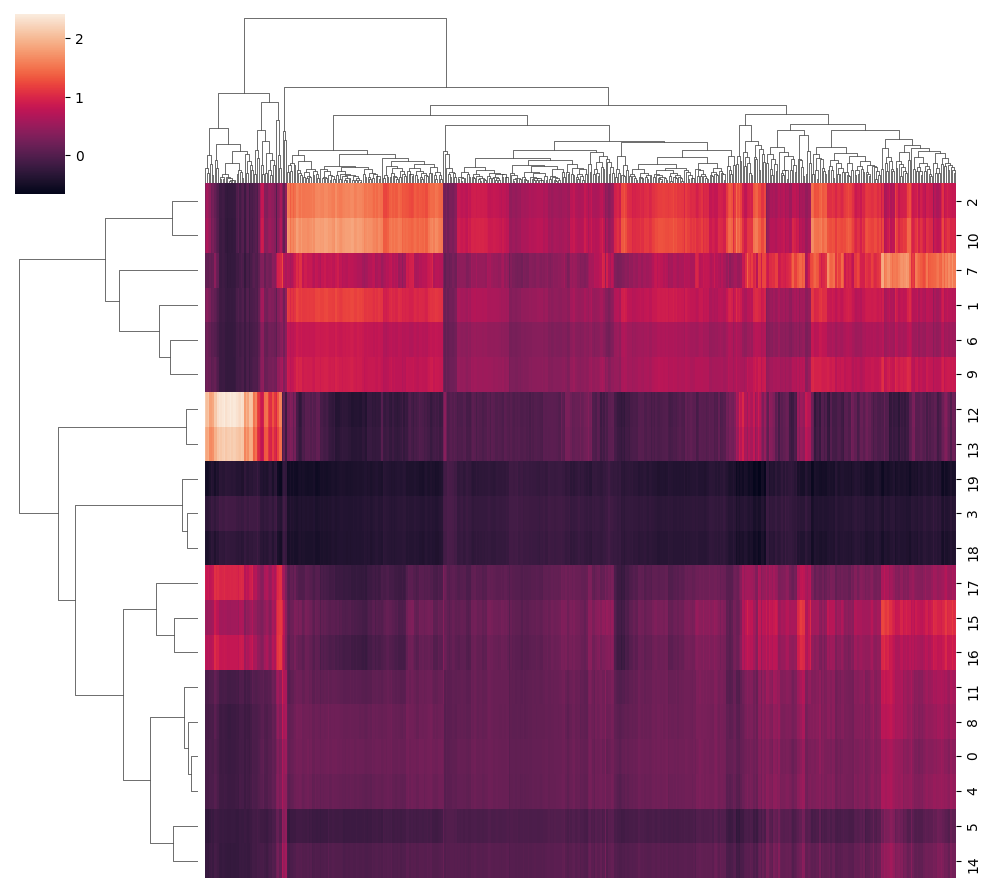

In [161]:
df = dtype_to_df['xenium'].copy()
obj = sns.clustermap(df)
obj.ax_heatmap.set_xticks([])

In [162]:
from scipy.cluster import hierarchy

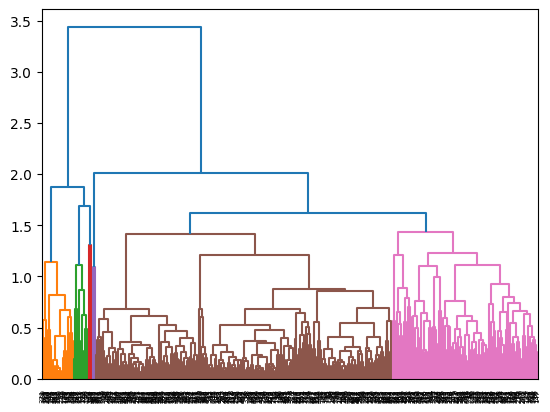

In [167]:
dn = hierarchy.dendrogram(obj.dendrogram_col.linkage, orientation='top', color_threshold=1.44)
cluster_to_feats = {c:[] for c in set(dn['leaves_color_list'])}
for i, label in zip(dn['leaves'], dn['leaves_color_list']):
    cluster_to_feats[label].append(df.columns[i])

In [176]:
sorted(cluster_to_feats.keys())

['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

In [ ]:
import enrichrpy.enrichr as een
import enrichrpy.plotting as epl

In [181]:
genes = cluster_to_feats['C6']
df = een.get_pathway_enrichment(genes, gene_set_library='PanglaoDB_Augmented_2021')
epl.enrichment_dotplot(df, n=20, hue='Z-score', log=True)

alt.LayerChart(...)

In [159]:
dn.keys()

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list', 'leaves_color_list'])

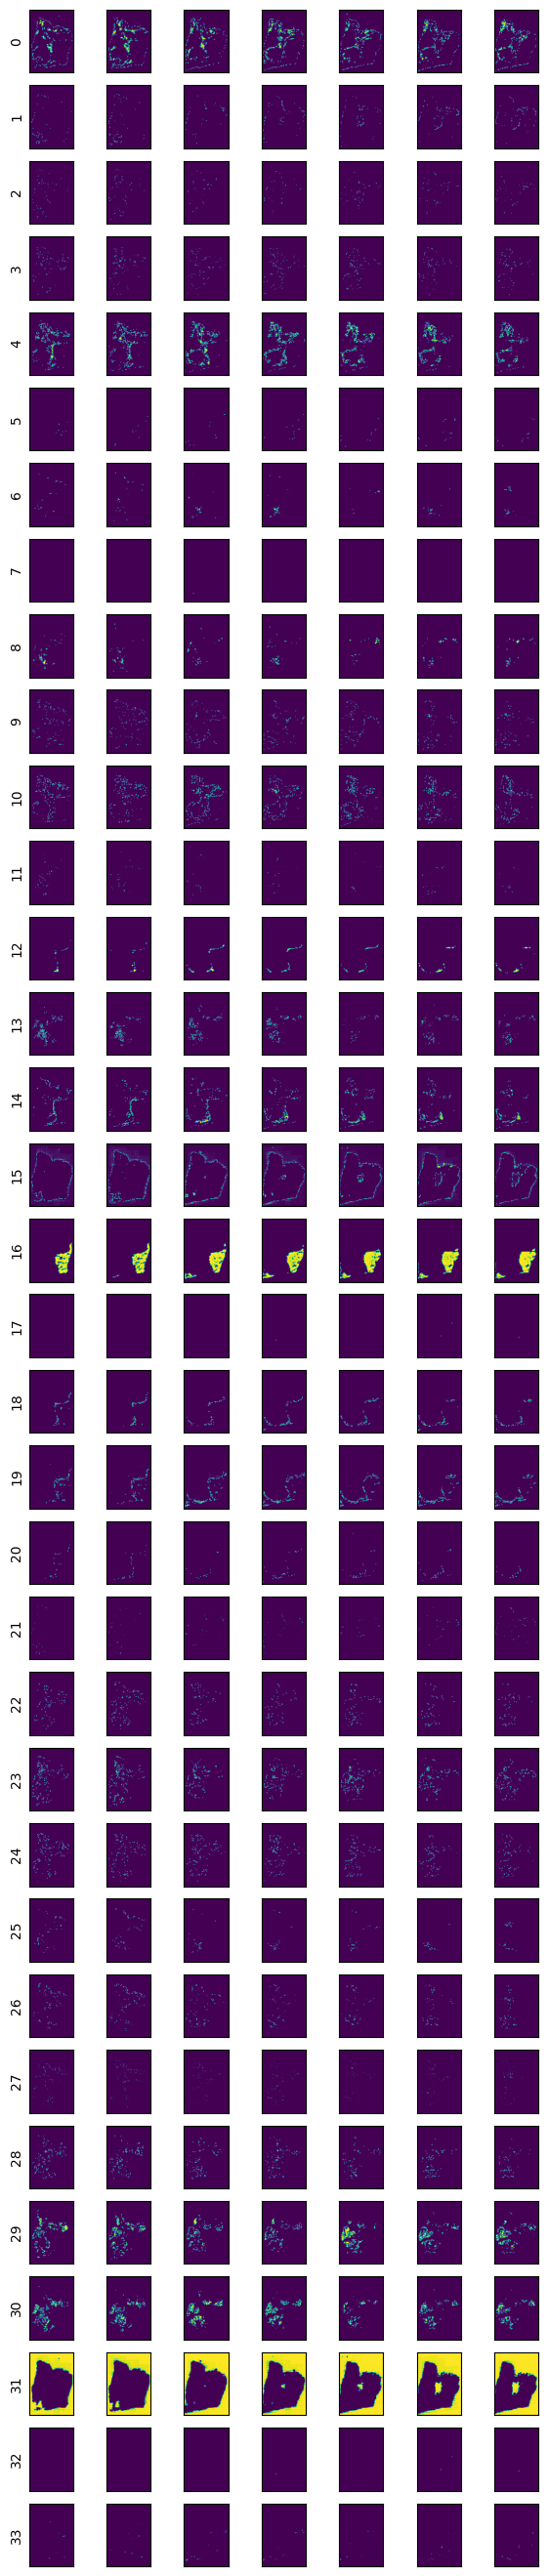

In [68]:
mushroom.display_cluster_probs('multiplex', level=-1)

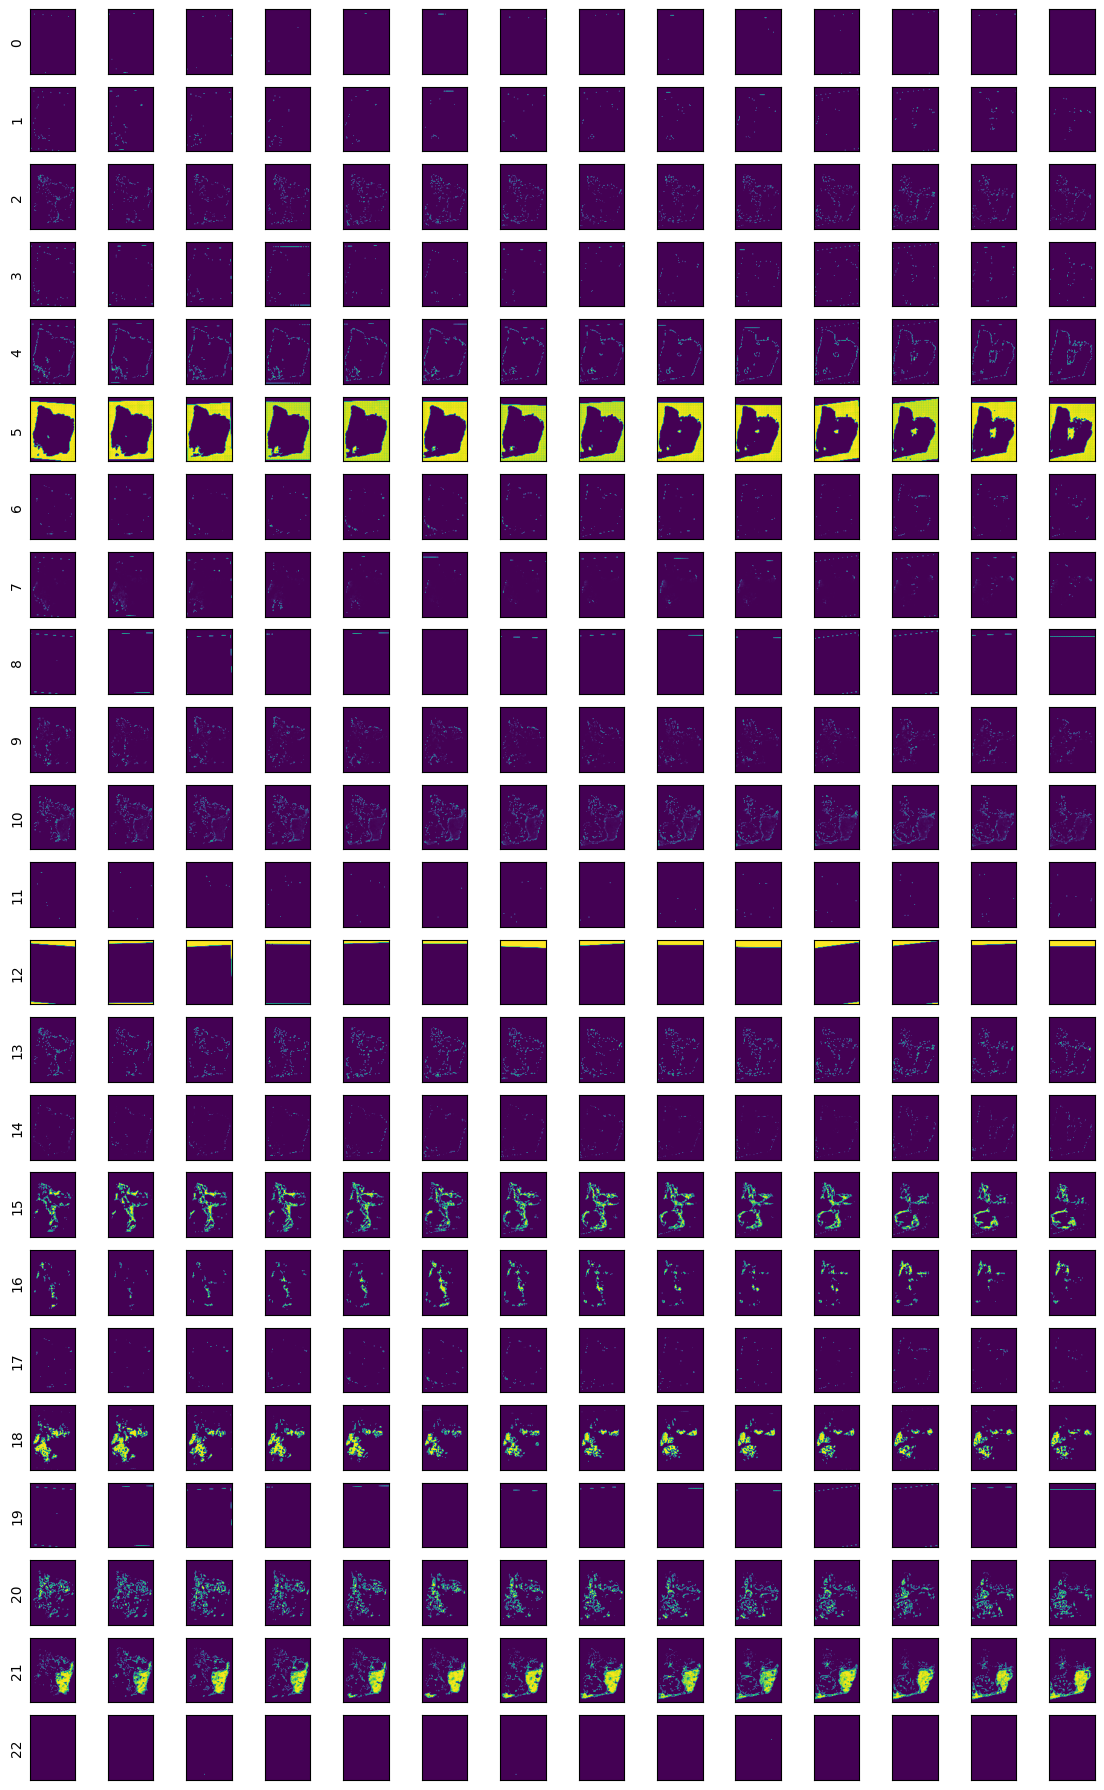

In [69]:
mushroom.display_cluster_probs('he', level=-1)

In [86]:
prefix = os.path.join(out_dir, f'clusters')
for dtype in mushroom.dtype_to_volume.keys():
    for i in range(3):
        root = prefix + f'_{dtype}_axis{i}'
        is_probs = False
        volume = mushroom.dtype_to_volume[dtype]
        vis_utils.volume_to_gif(volume, is_probs, root + '_section.gif', axis=i)
        
        if i in [1, 2]:
            rgb = vis_utils.display_labeled_as_rgb(volume[0], preserve_indices=True)
            vis_utils.save_reference_gif(rgb, root + '_ref.gif', axis=i-1)
        
        

In [213]:
mushroom.save()

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-01-29_21_25_55_078492/outputs


In [252]:
new = Mushroom.from_config(
    '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-01-29_21_25_55_078492/outputs/config.yaml',
    accelerator='cpu'
)

INFO:root:loading spore for he
INFO:root:starting he processing
INFO:root:14 sections detected: ['s0', 's1', 's4', 's7', 's8', 's10', 's11', 's12', 's15', 's16', 's17', 's20', 's23', 's24']
INFO:root:processing sections
INFO:root:generating image data for section s0
INFO:root:generating image data for section s1
INFO:root:generating image data for section s4
INFO:root:generating image data for section s7
INFO:root:generating image data for section s8
INFO:root:generating image data for section s10
INFO:root:generating image data for section s11
INFO:root:generating image data for section s12
INFO:root:generating image data for section s15
INFO:root:generating image data for section s16
INFO:root:generating image data for section s17
INFO:root:generating image data for section s20
INFO:root:generating image data for section s23
INFO:root:generating image data for section s24
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 14 sections detec

Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore


Predicting: |                                                                                                 …

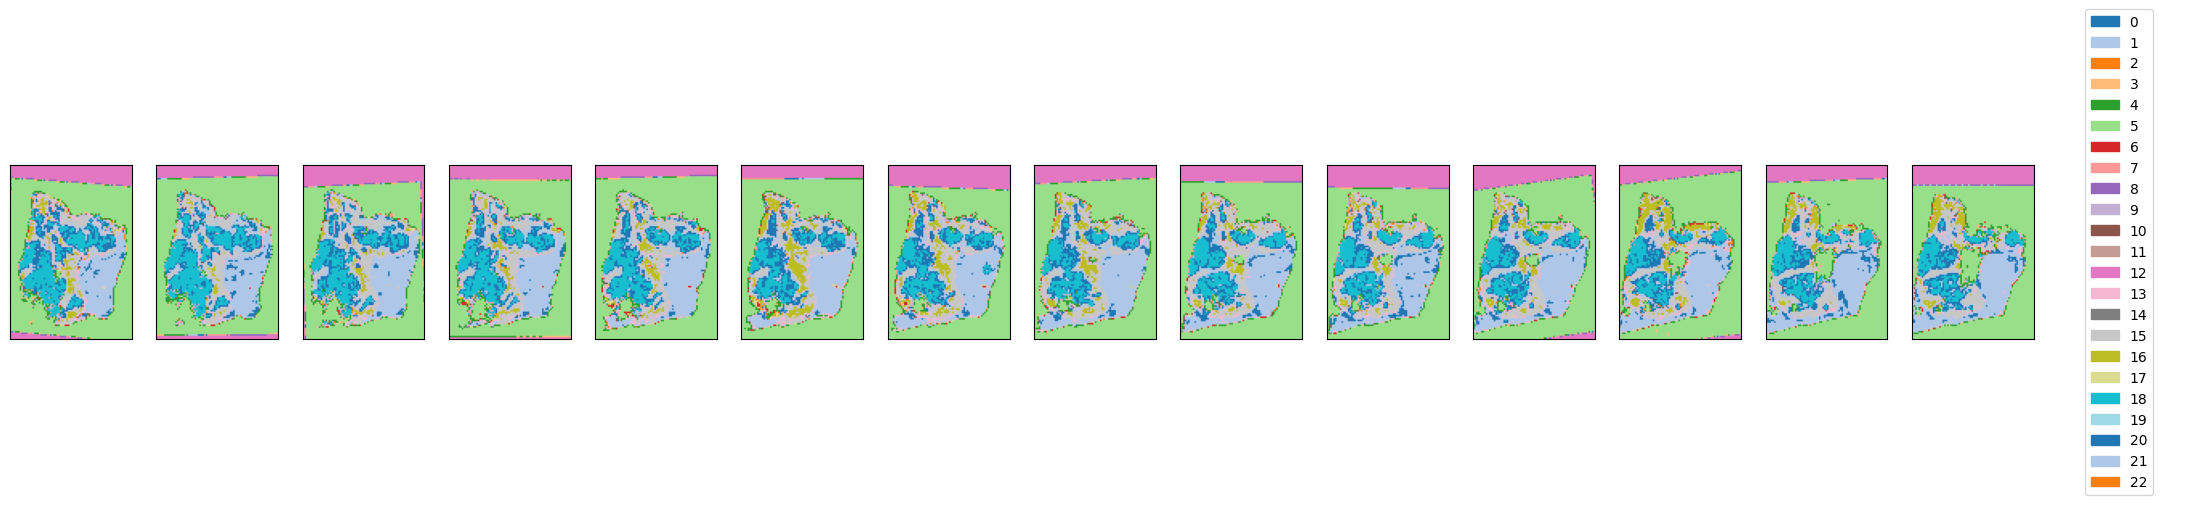

In [253]:
new.display_clusters('he')